In [1]:
import torch
from torchvision.datasets import CelebA
from torchvision.transforms.v2 import (
    CenterCrop,
    Compose,
    ToDtype,
    ToImage,
)

# Initial datatype of the images, will be converted by autocast later
DTYPE = torch.float32
# Download the dataset if it is not already downloaded
DOWNLOAD = False

normal_transform = Compose([CenterCrop(178), ToImage(), ToDtype(DTYPE, scale=True)])

test = CelebA("data", "test", download=DOWNLOAD, transform=normal_transform)

In [2]:
from mymodel import NEW_ATTRIBUTES

ATTRIBUTES = test.attr_names[:-1]

MAPPING = torch.IntTensor([ATTRIBUTES.index(attribute) for attribute in NEW_ATTRIBUTES])


def transform_y(y: torch.Tensor):
    """Transforms the input y (label) by applying the mapping from old to new attributes.
    This is needed, because the FFN head of the model has a different ordering of attributes.

    Args:
        y (torch.Tensor): The input tensor of shape (batch_size, num_attributes).

    Returns:
        torch.Tensor: The transformed tensor of shape (batch_size, num_selected_attributes).
    """
    return y.index_select(1, MAPPING)

/Users/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from mymodel import MyModel
from torch import cuda
from torch.backends import mps

device = "cuda" if cuda.is_available() else "mps" if mps.is_available() else "cpu"
print(f"Using device: {device}")

MAPPING = MAPPING.to(device)

BATCH_SIZE = 64

model = MyModel(batch_size=BATCH_SIZE).to(device)

Using device: mps


In [4]:
import coremltools as ct
import torch
from torch import load
from torch.nn import BCELoss
from torch.utils.data import DataLoader

BATCH_SIZE = 1

model = MyModel(batch_size=BATCH_SIZE)
# This is the trained.pth file that is created after the initial training
model.load_state_dict(load("./data/trained.pth", map_location=device))
model.to(device)

SAMPLE = 123

example = test[SAMPLE][0]

example = example.unsqueeze(0).to(device)


@torch.no_grad()
def trace(model, example):
    model.eval()
    return torch.jit.trace(model, example)


traced_model = trace(model, example)

coreml_model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=example.shape, name="input")],
    outputs=[ct.TensorType(name="attribute_labels")],
)

Torch version 2.2.1 has not been tested with coremltools. You may run into unexpected errors. Torch 2.1.0 is the most recent version that has been tested.
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 442.88 passes/s]


In [5]:
coreml_model.predict({"input": example.cpu().numpy()})

{'attribute_labels': array([[8.3740234e-01, 1.5449524e-04, 2.3269653e-04, 1.1558533e-03,
         9.9853516e-01, 5.8886719e-01, 3.4084320e-03, 4.2041016e-01,
         9.9853516e-01, 0.0000000e+00, 8.2910156e-01, 3.4545898e-01,
         0.0000000e+00, 2.2509766e-01, 0.0000000e+00, 0.0000000e+00,
         2.2792816e-04, 9.7998047e-01, 2.7084351e-04, 9.5748901e-03,
         6.9519043e-02, 4.2724609e-01, 4.1961670e-05, 3.5591125e-03,
         2.4243164e-01, 2.0410156e-01, 7.4310303e-03, 3.3782959e-02,
         0.0000000e+00, 0.0000000e+00, 3.2844543e-03, 0.0000000e+00,
         9.9951172e-01, 0.0000000e+00, 1.2245178e-02, 2.5170898e-01,
         1.6189575e-02, 9.0551376e-04, 2.7938843e-02, 1.0974121e-01]],
       dtype=float32)}

In [16]:
def test_loop(dataloader, model, loss_fn, device):
    num_batches = len(dataloader)
    test_loss = 0
    total, correct = num_batches * 40, 0
    recall, recall_total = 0, 0
    specificity, specificity_total = 0, 0

    correct_attributes = [0] * 40
    baseline = [0] * 40

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device=device, dtype=DTYPE)
        y = transform_y(y)
        pred = model.predict({"input": x.cpu().numpy()})["attribute_labels"]
        pred = torch.tensor(pred, device=device)
        test_loss += loss_fn(pred, y)
        pred_binary = (pred > 0.5).type(torch.float)
        recall += ((y == 1) & (pred_binary == y)).sum().item()
        specificity += ((y == 0) & (pred_binary == y)).sum().item()
        correct_attributes += (
            (pred_binary == y).type(torch.float).sum(dim=0).cpu().numpy()
        )
        baseline += y.sum(dim=0).cpu().numpy()

    test_loss /= num_batches

    correct = recall + specificity
    correct /= total

    recall_total = baseline.sum()
    recall = recall / recall_total

    specificity_total = total - baseline.sum()
    specificity = specificity / specificity_total
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    print(f"Recall: {(100*recall):>0.1f}%")
    print(f"Specificity: {(100*specificity):>0.1f}%")
    return (
        correct_attributes / (num_batches),
        baseline / (num_batches),
    )

In [17]:
test_loader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    num_workers=2,
)

attribute_accuracy, baseline = test_loop(test_loader, coreml_model, BCELoss(), device)
baseline = [item if item > 0.5 else 1 - item for item in baseline]

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.203570
Recall: 73.1%
Specificity: 96.3%


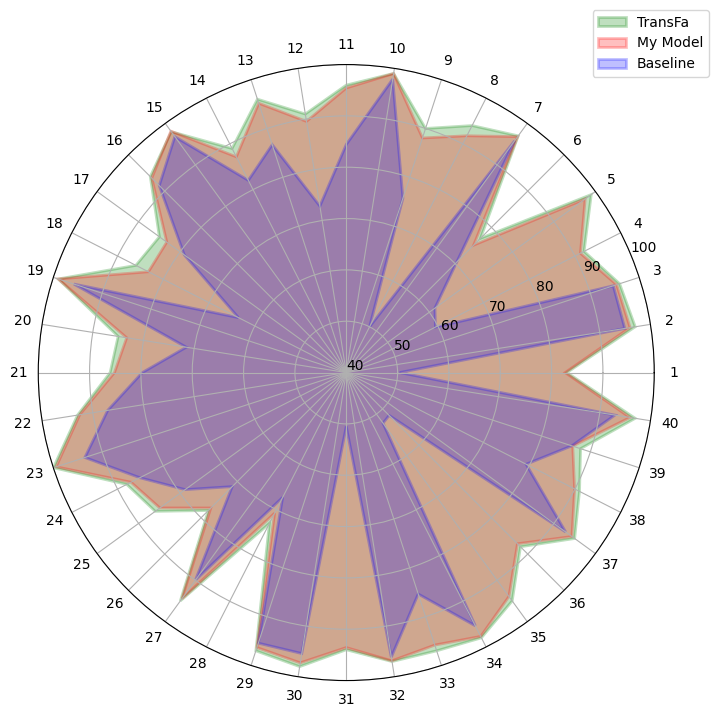

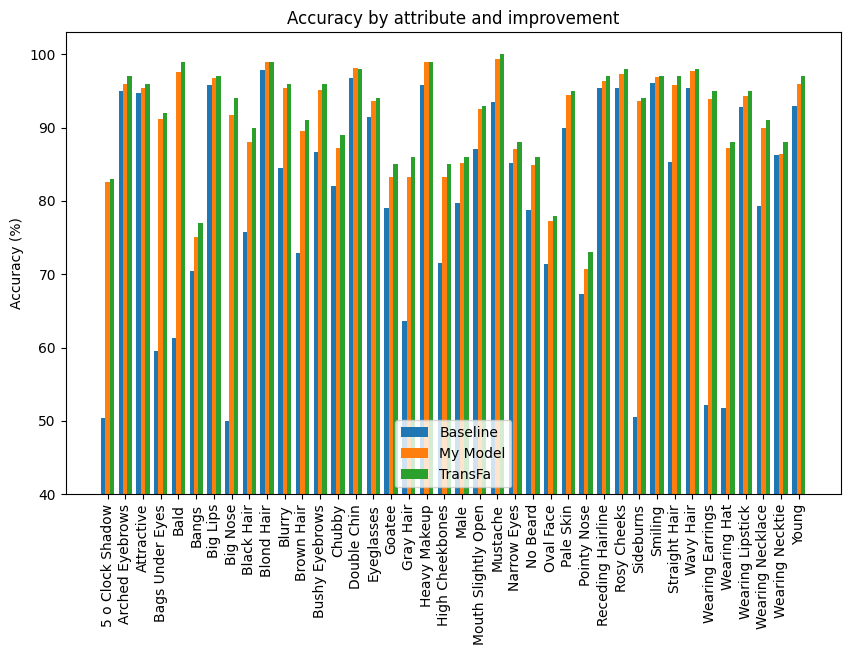

In [18]:
import matplotlib.pyplot as plt
import numpy as np

labels = [label.replace("_", " ") for label in ATTRIBUTES]

TRANSFA = [
    0.83,
    0.97,
    0.96,
    0.92,
    0.99,
    0.77,
    0.97,
    0.94,
    0.90,
    0.99,
    0.96,
    0.91,
    0.96,
    0.89,
    0.98,
    0.94,
    0.85,
    0.86,
    0.99,
    0.85,
    0.86,
    0.93,
    1.00,
    0.88,
    0.86,
    0.78,
    0.95,
    0.73,
    0.97,
    0.98,
    0.94,
    0.97,
    0.97,
    0.98,
    0.95,
    0.88,
    0.95,
    0.91,
    0.88,
    0.97,
]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(
    angles,
    [i - 0.4 for i in TRANSFA],
    color="green",
    alpha=0.25,
    edgecolor="green",
    linewidth=2,
)
ax.fill(
    angles,
    [i - 0.4 for i in attribute_accuracy],
    color="red",
    alpha=0.25,
    edgecolor="red",
    linewidth=2,
)
ax.fill(
    angles,
    [i - 0.4 for i in baseline],
    color="blue",
    alpha=0.25,
    edgecolor="blue",
    linewidth=2,
)

ax.set_rmax(0.6)
ax.set_rticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_yticklabels([40, 50, 60, 70, 80, 90, 100])
ax.set_xticks(angles)
# ax.set_xticklabels([f"{label}: {attribute_accuracy[i]*100:.2f}%" for i, label in enumerate(labels)])
ax.set_xticks(angles)
ax.set_xticklabels([f"{i+1}" for i in range(len(labels))])  # Change labels to index+1


# Add a legend to the polar plot
ax.legend(
    ["TransFa", "My Model", "Baseline"], loc="upper right", bbox_to_anchor=(1.1, 1.1)
)

plt.show()


improved = attribute_accuracy

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, [i - 0.4 for i in baseline], width, label="Baseline")
rects2 = ax.bar(x, [i - 0.4 for i in improved], width, label="My Model")
rects3 = ax.bar(x + width, [i - 0.4 for i in TRANSFA], width, label="TransFa")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy by attribute and improvement")
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_yticklabels([40, 50, 60, 70, 80, 90, 100])
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
# Add a legend to the bar plot
ax.legend(
    ["Baseline", "My Model", "TransFa"], loc="lower center", bbox_to_anchor=(0.5, 0.0)
)


plt.show()